# Model

## Logistic regression

In [49]:
# Load packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [50]:
# Load Data 


## Non imputed Data 
df_train = pd.read_parquet("../data/processed/merged/non_imputed/train.parquet")
df_val = pd.read_parquet("../data/processed/merged/non_imputed/validation.parquet")

df_train.drop(columns="pre_relief_refi_loan_seq_number", inplace=True)
df_val.drop(columns="pre_relief_refi_loan_seq_number", inplace=True)

## Imputed data
df_train_imp = pd.read_parquet("../data/processed/merged/imputed/train.parquet")
df_train_imp['first_time_homebuyer_flag'] = df_train_imp['first_time_homebuyer_flag'].fillna(False) # add this line into the imputer

df_val_imp = pd.read_parquet("../data/processed/merged/imputed/validation.parquet")

### Traitement des variables 

In [ ]:
# Colonne qui sera supprimé pendant la phase de traitement
drop_list_columns = []

In [51]:
# Corrélation cell 



# MAP each column into a data types categories (to better select columns)

from collections import defaultdict

dict_types = {
 'credit_score': 'continuous',
 'first_payment_date': 'date',
 'first_time_homebuyer_flag': 'bool',            # Y/N, 9 -> NA
 'maturity_date': 'date',
 'msa_md': 'category',
 'mi_percent': 'continuous',                     # pas catégoriel
 'number_of_units': 'category',                  # 1–4, 99 -> NA (caté OK)
 'occupancy_status': 'category',
 'original_cltv': 'continuous',
 'original_dti': 'continuous',
 'original_upb': 'continuous',
 'original_ltv': 'continuous',
 'original_interest_rate': 'continuous',
 'channel': 'category',
 'ppm_flag': 'bool',                             # Y/N
 'amortization_type': 'category',                # FRM/ARM
 'property_state': 'category',
 'property_type': 'category',
 'postal_code': 'category',
 'loan_sequence_number': 'id',
 'loan_purpose': 'category',
 'original_loan_term': 'integer',                # nb de mois, pas une caté
 'number_of_borrowers': 'integer',               # petit entier
 'seller_name': 'category',
 'servicer_name': 'category',
 'super_conforming_flag': 'bool',                # Y / vide
 'pre_relief_refi_loan_seq_number': 'id_ref',    # clé de ref, pas une caté
 'special_eligibility_program': 'category',      # H/F/R/9
 'relief_refinance_indicator': 'bool',           # Y / vide
 'property_valuation_method': 'category',        # codes 1–4, 9 -> NA
 'interest_only_indicator': 'bool',              # Y/N
 'mi_cancellation_indicator': 'category',        # Y/N/7/9
 'default_24m': 'bool',
 'vintage': 'date'                               # ex. YYYY-Q à partir de FIRST_PAYMENT_DATE
}

# inversion type -> liste de colonnes
_dict_types_col = defaultdict(list)
for col, t in dict_types.items():
    _dict_types_col[t].append(col)

dict_types_col = dict(_dict_types_col)  # (optionnel) convertir en dict standard

cont_cols  = dict_types_col.get('continuous', [])
ord_cols   = dict_types_col.get('integer', [])      # ici: original_loan_term, number_of_borrowers (traités comme ordinal/binaire)
bools_cols = dict_types_col.get('bool', [])
cat_cols  = dict_types_col.get('category', []) + bools_cols



# Correlations cell

from scipy.stats import spearmanr, pointbiserialr, pearsonr, kendalltau
from scipy.stats import chi2_contingency
from itertools import combinations
import numpy as np

spearman_pairs  = {}
pearson_pairs   = {}
cramer_pairs    = {}
pb_pairs        = {}
kendall_pairs   = {}

# df_corr = df_train_imp
df_corr = df_train
# 1) Spearman : ordinal <-> continu (monotone)
for x in ord_cols:
    for y in cont_cols:
        s = df_corr[[x, y]].dropna()
        if s.empty: continue
        r, p = spearmanr(s[x], s[y])
        spearman_pairs[(x, y)] = (r, p)

# 2) Pearson : continu <-> continu (sans doublons ni diagonale)
for x, y in combinations(cont_cols, 2):
    s = df_corr[[x, y]].dropna()
    if s.empty: continue
    r, p = pearsonr(s[x], s[y])
    pearson_pairs[(x, y)] = (r, p)

# 3) Point-bisérial : continu <-> booléen binaire
bin_cols = [c for c in dict_types_col.get('bool', [])
            if set(df_corr[c].dropna().unique()).issubset({0,1,True,False})]
for x in cont_cols:
    for b in bin_cols:
        s = df_corr[[x, b]].dropna()
        if s.empty: continue
        r, p = pointbiserialr(s[x], s[b].astype(int))
        pb_pairs[(x, b)] = (r, p)   # <-- bug corrigé

# 4) Kendall tau-b : ordinal <-> ordinal (et en option ordinal <-> continu)
for x, y in combinations(ord_cols, 2):
    s = df_corr[[x, y]].dropna()
    if s.empty: continue
    tau, p = kendalltau(s[x], s[y], method="auto")  # tau-b avec correction des ties
    kendall_pairs[(x, y)] = (tau, p)

# Optionnel : Kendall pour ordinal <-> continu
for x in ord_cols:
    for y in cont_cols:
        s = df_corr[[x, y]].dropna()
        if s.empty: continue
        tau, p = kendalltau(s[x], s[y], method="auto")
        kendall_pairs[(x, y)] = (tau, p)

# 5) Cramér V corrigé : nominal/ordinal <-> nominal/ordinal
def cramers_v_corrected(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0: 
        return np.nan
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    phi2 = chi2 / n
    # Correction biais (Bergsma, 2013)
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = max(1e-12, min((kcorr-1), (rcorr-1)))
    return np.sqrt(phi2corr / denom)

cats = list(set(cat_cols) | set(ord_cols))  # traiter l'ordinal comme catégoriel ici
for a, b in combinations(cats, 2):
    s = df_corr[[a, b]].dropna()
    if s.empty: continue
    cramer_pairs[(a, b)] = cramers_v_corrected(s[a], s[b])


/Users/yoannpull/Library/Caches/pypoetry/virtualenvs/pd-calibration-NMoSp0fs-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/Users/yoannpull/Library/Caches/pypoetry/virtualenvs/pd-calibration-NMoSp0fs-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/Users/yoannpull/Library/Caches/pypoetry/virtualenvs/pd-calibration-NMoSp0fs-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/Users/yoannpull/Library/Caches/pypoetry/virtualenvs/pd-calibration-NMoSp0fs-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the c

In [52]:
# Shape the correlation into a long data frame


# ---------- 1) Fusion des dictionnaires en un tableau "long" ----------
def _dict_to_df(d, measure, has_p=True):
    rows = []
    for (x, y), val in d.items():
        # tolère (stat, p) ou (stat, p, n)
        if has_p:
            stat = val[0]
            pval = val[1]
            n = val[2] if (isinstance(val, (tuple, list)) and len(val) >= 3) else np.nan
        else:
            stat = val
            pval = np.nan
            n = np.nan
        rows.append({
            "var_x": x,
            "var_y": y,
            "measure": measure,
            "stat": float(stat),
            "p_value": float(pval) if pd.notna(pval) else np.nan,
            "n": float(n) if pd.notna(n) else np.nan,
            "abs_stat": abs(float(stat)),
        })
    return pd.DataFrame(rows)

dfs = []
if len(spearman_pairs): dfs.append(_dict_to_df(spearman_pairs, "spearman", has_p=True))
if len(pearson_pairs):  dfs.append(_dict_to_df(pearson_pairs,  "pearson",  has_p=True))
if len(pb_pairs):       dfs.append(_dict_to_df(pb_pairs,       "pointbiserial", has_p=True))
if len(kendall_pairs):  dfs.append(_dict_to_df(kendall_pairs,  "kendall_tau", has_p=True))
if len(cramer_pairs):   dfs.append(_dict_to_df(cramer_pairs,   "cramers_v", has_p=False))

assocs_long = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(
    columns=["var_x","var_y","measure","stat","p_value","n","abs_stat"]
)

# ---------- 2) Ajout des types de variables (utile pour filtrer) ----------
def _type_of(v):
    if v in bin_cols:  return "bin"
    if v in cont_cols: return "cont"
    if v in ord_cols:  return "ord"
    if v in cat_cols:  return "cat"
    return "unknown"

assocs_long["type_x"] = assocs_long["var_x"].map(_type_of)
assocs_long["type_y"] = assocs_long["var_y"].map(_type_of)

# ---------- 3) Tri + étoiles de significativité + q-values (FDR BH) ----------
def _stars(p):
    if pd.isna(p): return ""
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

assocs_long["sig"] = assocs_long["p_value"].apply(_stars)

# FDR Benjamini–Hochberg (si statsmodels dispo)
try:
    from statsmodels.stats.multitest import multipletests
    m = assocs_long["p_value"].notna()
    assocs_long.loc[m, "q_value"] = multipletests(assocs_long.loc[m, "p_value"], method="fdr_bh")[1]
except Exception:
    assocs_long["q_value"] = np.nan

assocs_long = assocs_long.sort_values(["measure", "abs_stat"], ascending=[True, False]).reset_index(drop=True)

# ---------- 4) Exemples d’usages rapides ----------
# a) Top 20 associations par mesure (en valeur absolue)
top20_by_measure = (
    assocs_long.groupby("measure", group_keys=False)
               .apply(lambda g: g.nlargest(20, "abs_stat"))
               .reset_index(drop=True)
)

# b) Pivots pour heatmaps (ex: Pearson et Cramér V)
pearson_pivot = (assocs_long.query("measure == 'pearson'")
                              .pivot(index="var_x", columns="var_y", values="stat"))
cramers_pivot = (assocs_long.query("measure == 'cramers_v'")
                              .pivot(index="var_x", columns="var_y", values="stat"))

# ---------- 5) Export CSV ----------
assocs_long.to_csv("associations_long.csv", index=False)
top20_by_measure.to_csv("associations_top20_by_measure.csv", index=False)

print("OK • assocs_long :", assocs_long.shape, "| Sauvé: associations_long.csv")
assocs_long



OK • assocs_long : (323, 11) | Sauvé: associations_long.csv


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_5677/7709586.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(20, "abs_stat"))


,var_x,var_y,measure,stat,p_value,n,abs_stat,type_x,type_y,sig,q_value
0,postal_code,property_state,cramers_v,0.999930,NaN,NaN,0.999930,cat,cat,,NaN
1,property_state,msa_md,cramers_v,0.951138,NaN,NaN,0.951138,cat,cat,,NaN
2,postal_code,msa_md,cramers_v,0.844495,NaN,NaN,0.844495,cat,cat,,NaN
3,servicer_name,seller_name,cramers_v,0.721675,NaN,NaN,0.721675,cat,cat,,NaN
4,channel,seller_name,cramers_v,0.609715,NaN,NaN,0.609715,cat,cat,,NaN
...,...,...,...,...,...,...,...,...,...,...,...
318,number_of_borrowers,original_ltv,spearman,-0.049660,0.0,NaN,0.049660,ord,cont,***,0.0
319,number_of_borrowers,credit_score,spearman,-0.048023,0.0,NaN,0.048023,ord,cont,***,0.0
320,number_of_borrowers,original_cltv,spearman,-0.047600,0.0,NaN,0.047600,ord,cont,***,0.0
321,number_of_borrowers,original_interest_rate,spearman,-0.046426,0.0,NaN,0.046426,ord,cont,***,0.0


In [53]:
dict_threshold = {
    "spearman": 0.70,
    "pearson": 0.70,
    "pointbiserial": 0.70,
    "kendall_tau": 0.60,
    "cramers_v": 0.60
}

pair_var = pd.DataFrame(columns=assocs_long.columns)

for k, v in dict_threshold.items():
    mask = (
        (assocs_long["measure"] == k) &
        (assocs_long["stat"].notna()) &
        (assocs_long["stat"] >= v)
    )
    concat_df = assocs_long[mask]
    pair_var = pd.concat([pair_var, concat_df], ignore_index=True)

print(pair_var)


            var_x           var_y    measure      stat  p_value   n  abs_stat  \
0   original_cltv    original_ltv    pearson  0.994727      0.0 NaN  0.994727   
1     postal_code  property_state  cramers_v  0.999930      NaN NaN  0.999930   
2  property_state          msa_md  cramers_v  0.951138      NaN NaN  0.951138   
3     postal_code          msa_md  cramers_v  0.844495      NaN NaN  0.844495   
4   servicer_name     seller_name  cramers_v  0.721675      NaN NaN  0.721675   
5         channel     seller_name  cramers_v  0.609715      NaN NaN  0.609715   

  type_x type_y  sig  q_value  
0   cont   cont  ***      0.0  
1    cat    cat           NaN  
2    cat    cat           NaN  
3    cat    cat           NaN  
4    cat    cat           NaN  
5    cat    cat           NaN  


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_5677/3985330454.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pair_var = pd.concat([pair_var, concat_df], ignore_index=True)


Gini value of the variable  loan_purpose : 0.12748813345127785


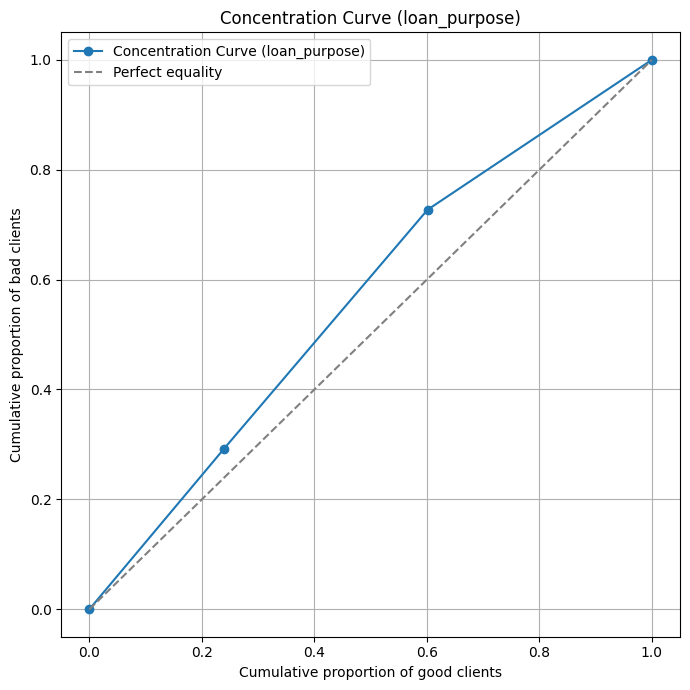

In [54]:

test_function = True


def build_client_distribution(
    cat_columns,
    df,
    target_col="default_24m",
    include_missing=True,
    missing_label="__MISSING__"
):
    """
    Build, for each categorical column, a dict of per-modality stats:
      - good_client_share: share of GOODs in this modality over all GOODs   P(mod | good)
      - bad_client_share : share of BADs  in this modality over all BADs    P(mod | bad)
      - population_share : share of total population in this modality
      - bad_rate         : default rate within the modality                 P(bad | mod)
      - n_total, n_good, n_bad
      - bad_share, good_share (same as bad_client_share/good_client_share; kept for clarity)

    Returns
    -------
    dict: {column: {modality: {...metrics...}}}
    """
    distribution_dict = {}

    # Robust to boolean target
    target = df[target_col].astype(int)

    # Precompute totals (avoid division by zero)
    n_total = len(df)
    n_bad   = int(target.sum())
    n_good  = int(n_total - n_bad)
    denom_bad  = n_bad  if n_bad  > 0 else 1
    denom_good = n_good if n_good > 0 else 1

    for col in cat_columns:
        # Handle missing as explicit category if requested
        col_series = df[col]
        if include_missing:
            col_series = col_series.astype("object").where(col_series.notna(), missing_label)

        tmp = pd.DataFrame({col: col_series, target_col: target})
        agg = tmp.groupby(col, dropna=not include_missing)[target_col].agg(["sum", "count"])
        agg.rename(columns={"sum": "n_bad", "count": "n_total"}, inplace=True)
        agg["n_good"] = agg["n_total"] - agg["n_bad"]

        # Within-modality default rate P(bad | mod)
        agg["bad_rate"] = agg["n_bad"] / agg["n_total"].where(agg["n_total"] > 0, 1)

        # Population share of modality
        agg["population_share"] = agg["n_total"] / n_total if n_total > 0 else 0.0

        # Shares w.r.t. class totals (for your good-vs-bad curve)
        agg["bad_share"]  = agg["n_bad"]  / denom_bad
        agg["good_share"] = agg["n_good"] / denom_good

        # Backward-compatible keys
        agg["bad_client_share"]  = agg["bad_share"]
        agg["good_client_share"] = agg["good_share"]

        distribution_dict[col] = agg.to_dict(orient="index")

    return distribution_dict



def build_cumulative_dataframe(variable_name, distribution_dict):
    """
    Returns a cumulative DataFrame (sorted by good_client_share).
    Columns: modality, good_client_share_cumsum, bad_client_share_cumsum
    """
    dist = distribution_dict[variable_name]
    items = sorted(dist.items(), key=lambda kv: kv[1]["good_client_share"])

    rows = []
    cum_good = cum_bad = 0.0
    for modality, shares in items:
        cum_good += shares["good_client_share"]
        cum_bad  += shares["bad_client_share"]
        rows.append({
            "modality": modality,
            "good_client_share_cumsum": cum_good,
            "bad_client_share_cumsum":  cum_bad
        })
    return pd.DataFrame(rows)


def gini_trapz(df_cum,
               y_col="good_client_share_cumsum",
               x_col="bad_client_share_cumsum",
               signed=True):
    """
    Indice de concentration signé : G = 1 - 2 * aire(y vs x).
    X = cumul des bons, Y = cumul des mauvais (convention actuelle).
    Si signed=False, renvoie la valeur absolue (>= 0).
    """
    df = df_cum[[x_col, y_col]].astype(float).copy().sort_values(x_col)

    # ajouter (0,0) si besoin
    if df.iloc[0, 0] > 0 or df.iloc[0, 1] > 0:
        df = pd.concat([pd.DataFrame({x_col: [0.0], y_col: [0.0]}), df], ignore_index=True)
    # ajouter (1,1) si besoin (tolérance)
    if (df.iloc[-1, 0] < 1 - 1e-12) or (df.iloc[-1, 1] < 1 - 1e-12):
        df = pd.concat([df, pd.DataFrame({x_col: [1.0], y_col: [1.0]})], ignore_index=True)

    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    area = np.trapezoid(y, x)  
    g = 1 - 2 * area
    return g if signed else abs(g)



def plot_concentration_curve(df_cum, variable_name=None,
                             title="Concentration Curve", theme=None):
    """
    Plots with X = cumulative good, Y = cumulative bad.
    """
    df = df_cum[["good_client_share_cumsum","bad_client_share_cumsum"]].copy()
    df = df.sort_values("good_client_share_cumsum")

    # add endpoints
    if df.iloc[0, 0] > 0 or df.iloc[0, 1] > 0:
        df = pd.concat([pd.DataFrame({"good_client_share_cumsum":[0.0],
                                      "bad_client_share_cumsum":[0.0]}),
                        df], ignore_index=True)
    if (df.iloc[-1, 0] < 1 - 1e-12) or (df.iloc[-1, 1] < 1 - 1e-12):
        df = pd.concat([df, pd.DataFrame({"good_client_share_cumsum":[1.0],
                                          "bad_client_share_cumsum":[1.0]})],
                       ignore_index=True)

    if theme:
        plt.style.use(theme)

    label = f"{title} ({variable_name})" if variable_name else title
    plt.figure(figsize=(7,7))
    plt.plot(df["good_client_share_cumsum"],
             df["bad_client_share_cumsum"],
             marker="o", linestyle="-", label=label)
    plt.plot([0,1],[0,1], color="gray", linestyle="--", label="Perfect equality")
    plt.title(label)
    plt.xlabel("Cumulative proportion of good clients")
    plt.ylabel("Cumulative proportion of bad clients")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if test_function :
    # Test of the functions  
    var = "loan_purpose"
    client_distribution = build_client_distribution(cat_cols,df_train_imp)
    df_cum = build_cumulative_dataframe(var,client_distribution)
    print(f"Gini value of the variable  {var} : {gini_trapz(df_cum)}")

    plot_concentration_curve(df_cum,var)

In [55]:
vars_list = (
    pd.concat([
        pair_var.loc[pair_var["measure"] == "cramers_v", "var_x"],
        pair_var.loc[pair_var["measure"] == "cramers_v", "var_y"]
    ])
    .unique()
    .tolist()
)

print(vars_list)
client_distribution = build_client_distribution(vars_list,df_train_imp)

for var in vars_list:
    df_cum = build_cumulative_dataframe(var, client_distribution)
    # print(var, "end:", df_cum["good_client_share_cumsum"].iloc[-1], df_cum["bad_client_share_cumsum"].iloc[-1])
    # plot_concentration_curve(df_cum)
    print(f"Gini value of the variable  {var} : {gini_trapz(df_cum)}")

['postal_code', 'property_state', 'servicer_name', 'channel', 'msa_md', 'seller_name']
Gini value of the variable  postal_code : -0.013740810506878587
Gini value of the variable  property_state : -0.03573344598052186
Gini value of the variable  servicer_name : -0.027707699545308273
Gini value of the variable  channel : 0.034917899078695136
Gini value of the variable  msa_md : 0.01797547589256554
Gini value of the variable  seller_name : 0.05237409799204462


In [56]:
# 1) Construire les clusters par seuil sur Cramér's V
def clusters_from_pairs(pair_var):
    mask = (pair_var["measure"] == "cramers_v")
    edges = pair_var.loc[mask, ["var_x", "var_y"]]

    # composantes connexes simples
    graph = {}
    for a,b in edges.to_numpy():
        graph.setdefault(a,set()).add(b)
        graph.setdefault(b,set()).add(a)
    visited, clusters = set(), []
    for v in graph:
        if v in visited: continue
        stack, comp = [v], set()
        while stack:
            u = stack.pop()
            if u in visited: continue
            visited.add(u); comp.add(u)
            stack.extend(graph.get(u,[])-visited)
        clusters.append(sorted(comp))
    # variables isolées (pas corrélées au-dessus du seuil)
    all_vars = set(pd.concat([pair_var.loc[mask,'var_x'], pair_var.loc[mask,'var_y']]).unique())
    isolated = sorted(all_vars - set().union(*clusters))
    clusters += [[v] for v in isolated]
    return clusters

# 2) Score de sélection par variable (exemple)
def variable_score(var, gini_dict, card_dict, na_rate_dict, 
                   w_g=1.0, w_card=0.1, w_na=0.1):
    return abs(gini_dict.get(var,0.0)) - w_card*np.log1p(card_dict.get(var,0)) - w_na*na_rate_dict.get(var,0.0)

# 3) Choisir un représentant / cluster
def pick_representatives(clusters, gini_dict, card_dict, na_rate_dict):
    reps = []
    for comp in clusters:
        scores = [(v, variable_score(v,gini_dict,card_dict,na_rate_dict)) for v in comp]
        # tie-breaker : cardinalité puis ordre alpha si égalité stricte
        scores.sort(key=lambda t: (t[1], -card_dict.get(t[0],0), t[0]))
        reps.append(scores[-1][0])
    return reps



# 1. Construire les clusters depuis pair_var
clusters = clusters_from_pairs(pair_var)
print("Clusters trouvés :", clusters)

# 2. Construire les dictionnaires auxiliaires
# Gini : tu as déjà la fonction gini_trapz
gini_dict = {}
for var in vars_list:
    df_cum = build_cumulative_dataframe(var, client_distribution)
    gini_dict[var] = gini_trapz(df_cum)

# Cardinalité (nb de modalités distinctes)
card_dict = {col: df_train_imp[col].nunique(dropna=True) for col in vars_list}

# Taux de NA
na_rate_dict = {col: df_train_imp[col].isna().mean() for col in vars_list}

# 3. Sélectionner un représentant par cluster
representatives = pick_representatives(clusters, gini_dict, card_dict, na_rate_dict)
print("Variables retenues :", representatives)
print("Not representatives :", [col for col in vars_list if col not in representatives])

Clusters trouvés : [['msa_md', 'postal_code', 'property_state'], ['channel', 'seller_name', 'servicer_name']]
Variables retenues : ['property_state', 'channel']
Not representatives : ['postal_code', 'servicer_name', 'msa_md', 'seller_name']


In [ ]:
# We initialize this vector in the first cell of the notebook
drop_list_columns = drop_list_columns + [col for col in vars_list if col not in representatives]
print(drop_list_columns)
# df_train_imp_test = df_train_imp.drop(columns=drop_list_columns)

['postal_code', 'servicer_name', 'msa_md', 'seller_name']

### Modelisation

AUC       : 0.6214
Brier     : 0.0149
Log Loss  : 0.0876
Mean predicted PD : 0.0462
Observed default rate : 0.0136


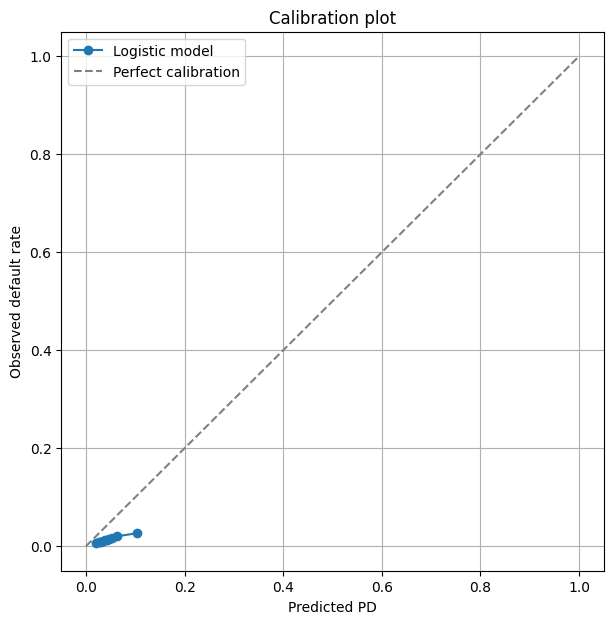

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# --- Préparation des données ---
drop_list_columns = drop_list_columns + ['first_payment_date', 'maturity_date', 'vintage']

df_train_model = df_train_imp.drop(columns=drop_list_columns)
df_val_model   = df_val_imp.drop(columns=drop_list_columns)

y_train = df_train_model["default_24m"].astype(int)
X_train = df_train_model.drop(columns="default_24m")

y_val = df_val_model["default_24m"].astype(int)
X_val = df_val_model.drop(columns="default_24m")

# Colonnes numériques / catégorielles
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# --- Pipeline de préprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=0))
])

# --- Fit ---
clf.fit(X_train, y_train)

# --- Prédictions ---
y_pred_proba = clf.predict_proba(X_val)[:, 1]

# --- Métriques ---
auc = roc_auc_score(y_val, y_pred_proba)
brier = brier_score_loss(y_val, y_pred_proba)
ll = log_loss(y_val, y_pred_proba)

print(f"AUC       : {auc:.4f}")
print(f"Brier     : {brier:.4f}")
print(f"Log Loss  : {ll:.4f}")
print(f"Mean predicted PD : {y_pred_proba.mean():.4f}")
print(f"Observed default rate : {y_val.mean():.4f}")

# --- Courbe de calibration ---
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(7, 7))
plt.plot(prob_pred, prob_true, marker="o", label="Logistic model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted PD")
plt.ylabel("Observed default rate")
plt.title("Calibration plot")
plt.legend()
plt.grid(True)
plt.show()

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
import numpy as np
import matplotlib.pyplot as plt

# --- Préparation des données (identique à toi) ---
drop_list_columns = drop_list_columns + ['first_payment_date', 'maturity_date', 'vintage']
df_train_model = df_train_imp.drop(columns=drop_list_columns)
df_val_model   = df_val_imp.drop(columns=drop_list_columns)

y_train = df_train_model["default_24m"].astype(int)
X_train = df_train_model.drop(columns="default_24m")
y_val   = df_val_model["default_24m"].astype(int)
X_val   = df_val_model.drop(columns="default_24m")

cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

base = Pipeline([
    ("prep", preproc),
    ("lr", LogisticRegression(max_iter=1000, random_state=0, class_weight="balanced"))
])

# --- Calibration isotonic en CV (5 folds sur l'échantillon train) ---
# (CalibratedClassifierCV refait l'entraînement en interne avec CV puis produit un modèle calibré)
cal = CalibratedClassifierCV(base_estimator=base, method="isotonic", cv=5)
cal.fit(X_train, y_train)

# --- Prédictions calibrées sur validation ---
p_val = cal.predict_proba(X_val)[:, 1]

# --- Métriques ---
auc  = roc_auc_score(y_val, p_val)
brier = brier_score_loss(y_val, p_val)
ll   = log_loss(y_val, p_val)
print(f"AUC (calibrated)      : {auc:.4f}")
print(f"Brier (calibrated)    : {brier:.5f}")
print(f"Log Loss (calibrated) : {ll:.5f}")
print(f"Mean predicted PD     : {p_val.mean():.4f}")
print(f"Observed default rate : {y_val.mean():.4f}")

# Baselines pour comparer
q = y_val.mean()
brier_base = q*(1-q)
ll_base = -(q*np.log(q) + (1-q)*np.log(1-q))
print(f"Baseline Brier (const={q:.4f}) : {brier_base:.5f}")
print(f"Baseline LogLoss               : {ll_base:.5f}")

# --- Courbe de calibration (quantiles) ---
prob_true, prob_pred = calibration_curve(y_val, p_val, n_bins=10, strategy="quantile")
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated (isotonic)")
plt.plot([0,1],[0,1], "--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted PD"); plt.ylabel("Observed default rate")
plt.title("Calibration plot (validation)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


TypeError: CalibratedClassifierCV.__init__() got an unexpected keyword argument 'base_estimator'